In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy')

fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [3]:
# data loader


class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        # super(LanguageModelDataLoader, self).__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        # concatenate your articles and build into batches
        
        # Step 1: Randomly shuffle all the articles from the WikiText-2 dataset.
        if self.shuffle:
            np.random.shuffle(self.dataset)
        # Step 2: Concatenate all text in one long string.
        all_text = np.concatenate(self.dataset, axis=0)
        # Step 3: Run a loop that returns a tuple of (input, label) on every iteration with yield.
        num_batch = (len(all_text) - 1) // self.batch_size
        print("num_batch:", num_batch)
        x = torch.from_numpy(all_text[:self.batch_size * num_batch].reshape(self.batch_size, -1).T).long()
        y = torch.from_numpy(all_text[1:self.batch_size * num_batch + 1].reshape(self.batch_size, -1).T).long()
        
        batch_idx = 0
        # Same setting as in the paper
        seq = 70
        prob = 0.95
        s = 5
        while batch_idx < num_batch:
            p = np.random.uniform(0, 1)
            base_seq = seq if p < prob else seq / 2
            length = int(np.random.normal(base_seq, s))
            x_batch = x[batch_idx: batch_idx + length]
            y_batch = y[batch_idx: batch_idx + length]
            batch_idx += length
            yield x_batch, y_batch


In [4]:
# model


class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = 400
        self.hidden_size = 1150
        self.num_layers = 3
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.rnn = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.scoring = nn.Linear(self.hidden_size, vocab_size)
        self.init_weights()

    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        batch_size = x.shape[1]
        embed = self.embedding(x)
        hidden = None
        output_lstm, hidden = self.rnn(embed, hidden)
        output_lstm_flatten = output_lstm.view(-1, self.hidden_size)
        output_flatten = self.scoring(output_lstm_flatten)
        return output_flatten.view(-1, batch_size, self.vocab_size)

    def init_weights(self):
        for m in self.modules():
            if type(m) == nn.Embedding:
                nn.init.uniform_(m.weight.data, a=-0.1, b=0.1)
            elif type(m) == nn.LSTM:
                nn.init.uniform_(m.weight_hh_l0, a=-1/np.sqrt(self.hidden_size), b=1/np.sqrt(self.hidden_size))

In [ ]:
# model trainer


class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.to(DEVICE)
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train()  # set to training mode
        epoch_loss = 0
        num_batches = 0
        print("begin training!")
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
            print("batch: {}".format(batch_num))
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f' % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        print("train batch!")
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = self.model(inputs)
        loss = self.criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    def test(self):
        # don't change these
        self.model.eval()  # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model)  # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model)  # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model)  # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f' % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [92]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        inp = torch.from_numpy(inp).long().to(DEVICE)
        outputs = model(inp)
        return outputs[:, -1, :].cpu().detach().numpy()

    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
        inp = torch.from_numpy(inp).long().to(DEVICE)
        outputs = model(inp)
        _, current_word = torch.max(outputs[:, -1, :], dim=1)
        generated_words = torch.unsqueeze(current_word, 1)
        _, outputs = torch.max(outputs, dim=2)
        if forward > 1:
            for i in range(forward - 1):
                outputs = model(outputs)
                _, current_word = torch.max(outputs[:, -1, :], dim=1)
                current_word = torch.unsqueeze(current_word, 1)
                generated_words = torch.cat((generated_words, current_word), dim=1)
                _, outputs = torch.max(outputs, dim=2)
        return generated_words.cpu().detach().numpy()

In [93]:
# TODO: define other hyper-parameters here

NUM_EPOCHS = 1
BATCH_SIZE = 80
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1554602389


In [94]:
model = LanguageModel(len(vocab))
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [95]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    # trainer.train()
    model.load_state_dict(torch.load("experiments/checkpoint.pt", map_location="cpu")["state_dict"])
    model.to(DEVICE)
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch " + str(epoch) + " with NLL: " + str(best_nll))
        trainer.save()


inp shape: (32, 20)


outputs shape: torch.Size([32, 33278])
torch.Size([32])
tensor([31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353])
torch.Size([32, 1])
torch.Size([32, 20])


inp shape: (128, 30)


outputs shape: torch.Size([128, 33278])
torch.Size([128])
tensor([31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
        31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353, 31353,
      

torch.Size([128, 30])


generated_logits shape: (32, 10)


[VAL]  Epoch [1/1]   Loss: 6.9268
Saving model, predictions and generated output for epoch 0 with NLL: 6.926832


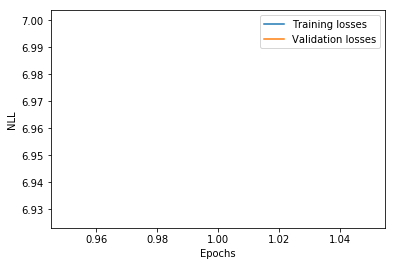

In [21]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [29]:
# see generated output
print(trainer.generated[-1])  # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | the
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | the
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | the
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | the
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in South Korea , notably where it moved ashore | the
Input | Output #7: The <unk> were condemned as <unk> by <unk> , who saw the riots as hampering attempts to resolve the situation | the
Input | Output #8: